In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
!nvidia-smi

Tue Feb 22 06:45:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    33W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from keras.applications.vgg19 import VGG19
#from keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = [256, 256]

train_path = '/content/drive/MyDrive/Datasets/PlantVillage/train'
valid_path = '/content/drive/MyDrive/Datasets/PlantVillage/val'

In [ ]:
base = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
base.output

80150528/80134624 [==============================] - 1s 0us/step


<KerasTensor: shape=(None, 8, 8, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
for layer in base.layers:
    layer.trainable = False

In [ ]:
folders = glob('/content/drive/MyDrive/Datasets/PlantVillage/train/*')
print(len(folders))

38


In [ ]:
x = Flatten()(base.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=base.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
import tensorflow as tf
from tensorflow.keras import optimizers

model.compile (loss = 'categorical_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc',tf.keras.metrics.TruePositives(),tf.keras.metrics.TrueNegatives(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 43444 images belonging to 38 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (256, 256),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 10871 images belonging to 38 classes.


In [ ]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=25)

Epoch 1/25
1358/1358 [==============================] - 15796s 12s/step - loss: 0.6084 - acc: 0.8348 - true_positives: 31714.0000 - true_negatives: 1605355.0000 - false_positives: 2073.0000 - false_negatives: 11730.0000 - precision: 0.9386 - recall: 0.7300 - val_loss: 0.2985 - val_acc: 0.9093 - val_true_positives: 9494.0000 - val_true_negatives: 401674.0000 - val_false_positives: 553.0000 - val_false_negatives: 1377.0000 - val_precision: 0.9450 - val_recall: 0.8733
Epoch 2/25
1358/1358 [==============================] - 204s 150ms/step - loss: 0.2195 - acc: 0.9312 - true_positives: 39499.0000 - true_negatives: 1605539.0000 - false_positives: 1889.0000 - false_negatives: 3945.0000 - precision: 0.9544 - recall: 0.9092 - val_loss: 0.2213 - val_acc: 0.9307 - val_true_positives: 9933.0000 - val_true_negatives: 401700.0000 - val_false_positives: 527.0000 - val_false_negatives: 938.0000 - val_precision: 0.9496 - val_recall: 0.9137
Epoch 3/25
1358/1358 [==============================] - 204s 1

In [ ]:
tf.version.VERSION

'2.8.0'

In [ ]:
from tensorflow.keras.models import load_model

model.save('VGG19_multi_1.h5')

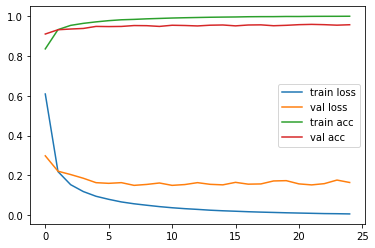

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

In [ ]:
test_dir = '/content/drive/MyDrive/Datasets/PlantVillage/val'
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory (
                test_dir,
                target_size=(256,256),
                batch_size=32,
                class_mode='categorical')

Found 10871 images belonging to 38 classes.


In [ ]:
model.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.16473762691020966,
 0.955845832824707,
 10370.0,
 401774.0,
 453.0,
 501.0,
 0.9581446647644043,
 0.9539141058921814]

In [ ]:
test_dir = '/content/drive/MyDrive/Datasets/PlantVillage/val'
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory (
                test_dir,
                target_size=(256,256),
                batch_size=32,
                class_mode='categorical',
                shuffle= False)

Found 10871 images belonging to 38 classes.


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_pred1 = model.predict(test_generator)
y_pred1=np.argmax(y_pred1,axis=1)
print(y_pred1)

y_true=np.expand_dims(test_generator.classes, axis=1)
print(y_true)

print(classification_report(test_generator.classes, y_pred1))

[ 0  0  0 ... 37 37 37]
[[ 0]
 [ 0]
 [ 0]
 ...
 [37]
 [37]
 [37]]
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       126
           1       0.97      0.98      0.98       125
           2       0.98      0.91      0.94        55
           3       0.97      0.96      0.96       329
           4       0.99      0.98      0.98       300
           5       0.96      1.00      0.98       210
           6       1.00      0.99      1.00       170
           7       0.85      0.82      0.83       103
           8       1.00      0.99      0.99       239
           9       0.85      0.89      0.87       197
          10       0.99      1.00      1.00       233
          11       0.96      0.93      0.94       236
          12       0.94      0.97      0.96       276
          13       0.99      1.00      1.00       215
          14       1.00      0.98      0.99        84
          15       1.00      0.99      1.00      1112
          16   